<a href="https://colab.research.google.com/github/GeneA2003/Poop/blob/main/FinalProjectIntrotoAI_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Read Codeblock

In [1]:
from typing import Literal
import numpy as np

DATASET_INFO = {
    "digit": {
        "images": {
            "train": "data/digitdata/trainingimages",
            "validation": "data/digitdata/validationimages",
            "test": "data/digitdata/testimages",
        },
        "labels": {
            "train": "data/digitdata/traininglabels",
            "validation": "data/digitdata/validationlabels",
            "test": "data/digitdata/testlabels",
        },
        "width": 28,
        "height": 28,
    },
    "face": {
        "images": {
            "train": "data/facedata/facedatatrain",
            "validation": "data/facedata/facedatavalidation",
            "test": "data/facedata/facedatatest",
        },
        "labels": {
            "train": "data/facedata/facedatatrainlabels",
            "validation": "data/facedata/facedatavalidationlabels",
            "test": "data/facedata/facedatatestlabels",
        },
        "width": 60,
        "height": 70,
    },
}


def load_data(
        dataset: Literal["digit", "face"],
        split: Literal["train", "validation", "test"],
):
    info = DATASET_INFO[dataset]

    # imgs
    ipath = info["images"][split]
    with open(ipath) as f:
        ilines = f.readlines()

    ibuf = np.zeros(shape=(len(ilines), info["width"]), dtype=np.uint8)

    for row, line in enumerate(ilines):
        for col, ch in enumerate(line):
            if ch == " ":
                pixel = 0
            elif ch == "+":
                pixel = 1
            elif ch == "#":
                pixel = 2
            else:
                continue
            ibuf[row, col] = pixel

    ibuf = ibuf.reshape(len(ilines) // info["height"], info["height"], info["width"])

    # labels
    lpath = info["labels"][split]
    with open(lpath) as f:
        llines = f.readlines()

    lbuf = np.zeros(shape=(len(llines)), dtype=np.uint8)
    for i, label in enumerate(llines):
        lbuf[i] = int(label)

    return ibuf, lbuf

imports

In [2]:
# core libraries
import numpy as np
import random
import time
import zipfile

# charts and graphs
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
import seaborn as sns
import matplotlib
import warnings

Unzip and Load Data

In [3]:
if not os.path.exists("data"):
    with zipfile.ZipFile("data.zip", "r") as zip_ref:
        zip_ref.extractall("data")
        
# filepaths
train_data_file = "data/digitdata/trainingimages"
train_label_file = "data/digitdata/traininglabels"
val_data_file = "data/digitdata/validationimages"
val_label_file = "data/digitdata/validationlabels"
test_data_file = "data/digitdata/testimages"
test_label_file = "data/digitdata/testlabels"

face_train_data_file = "data/facedata/facedatatrain"
face_train_label_file = "data/facedata/facedatatrainlabels"
face_val_data_file   = "data/facedata/facedatavalidation"
face_val_label_file  = "data/facedata/facedatavalidationlabels"
face_test_data_file  = "data/facedata/facedatatest"
face_test_label_file = "data/facedata/facedatatestlabels"

def read_data_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    return [line.rstrip("\n") for line in lines]

def extract_features(raw_data):
    features = []
    for i in range(0, len(raw_data), 28):
        image = raw_data[i:i+28]
        feature = [1 if ch != ' ' else 0 for row in image for ch in row]
        features.append(feature)
    return features


def read_labels(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    return [int(line.strip()) for line in lines]

def load_dataset(data_file, label_file, size=None):
    raw_data = read_data_file(data_file)
    raw_labels = read_labels(label_file)

    features = extract_features(raw_data)
    if size is not None:
        combined = list(zip(features, raw_labels))
        random.shuffle(combined)
        features, raw_labels = zip(*combined[:size])

    return list(features), list(raw_labels)


Hyperparamaeters

In [4]:
DIGIT_UNROLLED_FEATURES = 28 * 28
FACE_UNROLLED_FEATURES = 60 * 70
NUM_CLASSES = 10
LEARNING_RATE = 0.1
EPOCHS = 10
DATA_POINT_PERC = 10
FACE_CLASSES = 2


# Helper Functions

In [5]:
# Helper Functions
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return e_x / e_x.sum(axis=0, keepdims=True)


Perception Class

In [ ]:
#  Perceptron model and CSV utilities
class Perceptron:
    # single‑image prediction used everywhere
    def _predict_label(self, pixel):
        lin_output = np.dot(pixel, self.weights) + self.bias      # shape (C,)
        probs      = softmax(lin_output)                          # 1‑D softmax
        return np.argmax(probs)

    # digit training (per‑sample update, epoch‑by‑epoch prints)
    def trainDigit(self, images, labels, frac):
        vimgs, vlbls = load_data("digit", "validation")
        max_len      = int(images.shape[0] * frac)
        subset       = images[:max_len, :]

        for epoch in range(EPOCHS):
            correct = 0
            for idx, pixel in enumerate(subset):
                lbl = np.zeros(NUM_CLASSES)
                lbl[labels[idx]] = 1

                lin_output = np.dot(pixel, self.weights) + self.bias
                probs      = softmax(lin_output)
                error      = lbl - probs

                if labels[idx] == np.argmax(probs):
                    correct += 1

                self.weights += LEARNING_RATE * np.outer(error, pixel).T
                self.bias    += LEARNING_RATE * error

            train_acc = correct / max_len
            val_acc   = self.test_digit(vimgs, vlbls, -1,
                                        self.weights, self.bias)
            print(f"digit | pct={frac:.1f} | epoch={epoch} "
                  f"| train_acc={train_acc:.3f} | val_acc={val_acc:.3f}")

    # face training
    def trainFace(self, images, labels, frac):
        vimgs, vlbls = load_data("face", "validation")
        max_len      = int(images.shape[0] * frac)
        subset       = images[:max_len, :]

        for epoch in range(EPOCHS):
            correct = 0
            for idx, pixel in enumerate(subset):
                lbl = np.zeros(FACE_CLASSES)
                lbl[labels[idx]] = 1

                lin_output = np.dot(pixel, self.weights) + self.bias
                probs      = softmax(lin_output)
                error      = lbl - probs

                if labels[idx] == np.argmax(probs):
                    correct += 1

                self.weights += LEARNING_RATE * np.outer(error, pixel).T
                self.bias    += LEARNING_RATE * error

            train_acc = correct / max_len
            val_acc   = self.test_face(vimgs, vlbls, -1,
                                       self.weights, self.bias)
            print(f"face  | pct={frac:.1f} | epoch={epoch} "
                  f"| train_acc={train_acc:.3f} | val_acc={val_acc:.3f}")

    # digit test helper (per‑sample loop)
    def test_digit(self, images, labels, epoch, weights, bias):
        images = images.reshape(images.shape[0], -1)
        correct = sum(
            1 for px, lab in zip(images, labels)
            if np.argmax(softmax(np.dot(px, weights) + bias)) == lab
        )
        return correct / len(images)

    # face test helper
    def test_face(self, images, labels, epoch, weights, bias):
        images = images.reshape(images.shape[0], -1)
        correct = sum(
            1 for px, lab in zip(images, labels)
            if np.argmax(softmax(np.dot(px, weights) + bias)) == lab
        )
        return correct / len(images)


# CSV writer: trial‑level log + summary
def save_perceptron_csvs(rows, dataset):
    df_new = pd.DataFrame(rows)
    all_path = f"{dataset}_perc_all_trials.csv"
    try:
        df_all = pd.concat([pd.read_csv(all_path), df_new], ignore_index=True)
    except FileNotFoundError:
        df_all = df_new
    df_all.to_csv(all_path, index=False)

    summary = (
        df_all.groupby("pct")
              .agg(train_time_mean=("train_time", "mean"),
                   train_time_std =("train_time", "std"),
                   test_acc_mean  =("test_acc",  "mean"),
                   test_acc_std   =("test_acc",  "std"))
              .reset_index()
              .sort_values("pct")
    )
    summary.to_csv(f"{dataset}_perc_summary.csv", index=False)
    print(f"Saved {all_path} and {dataset}_perc_summary.csv")


# experiment runner: 5 trials × 10 fractions; writes CSVs
def perceptron_experiments(trials=5,
                           perc_steps=np.arange(0.1, 1.01, 0.1),
                           datasets=("digit", "face")):
    for ds in datasets:
        rows = []
        full_imgs, full_lbls = load_data(ds, "train")
        full_imgs = full_imgs.reshape(full_imgs.shape[0], -1)

        for pct in perc_steps:
            pct = round(pct, 2)
            m   = int(len(full_imgs) * pct)
            X_p, y_p = full_imgs[:m], full_lbls[:m]

            for trial in range(trials):
                model = Perceptron()
                if ds == "digit":
                    model.bias    = np.zeros(NUM_CLASSES)
                    model.weights = np.random.randn(
                        DIGIT_UNROLLED_FEATURES, NUM_CLASSES) * 0.01
                    train_fn = model.trainDigit
                    test_fn  = model.test_digit
                else:
                    model.bias    = np.zeros(FACE_CLASSES)
                    model.weights = np.random.randn(
                        FACE_UNROLLED_FEATURES, FACE_CLASSES) * 0.01
                    train_fn = model.trainFace
                    test_fn  = model.test_face

                start = time.time()
                train_fn(X_p, y_p, pct)
                train_time = time.time() - start

                X_test, y_test = load_data(ds, "test")
                test_acc = test_fn(X_test, y_test, -1,
                                   model.weights, model.bias)

                rows.append(dict(model="Perceptron",
                                 dataset=ds,
                                 pct=pct,
                                 trial=trial,
                                 train_time=train_time,
                                 test_acc=test_acc))

        save_perceptron_csvs(rows, ds)

**Sample Digit**

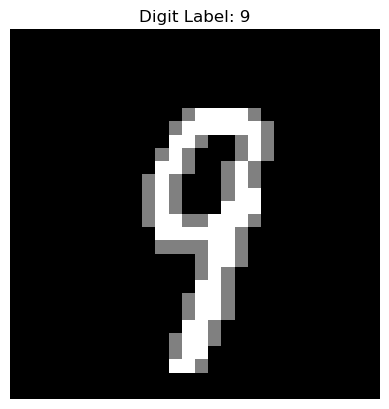

In [7]:
imgs, labels = load_data("digit", "train")

# Pick random image
idx = random.randint(0, len(imgs) - 1)
img = imgs[idx].reshape(28, 28)

# Display image
plt.imshow(img, cmap="gray")
plt.title("Digit Label: " + str(labels[idx]))
plt.axis("off")
plt.show()

**Sample Face**

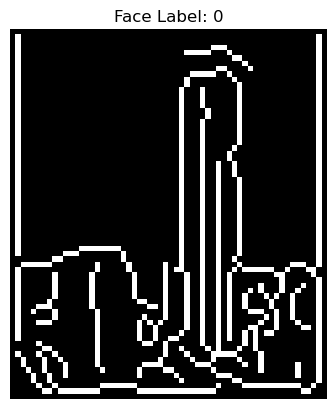

In [8]:
imgs, labels = load_data("face", "train")

idx = random.randint(0, len(imgs) - 1)

# Reshape and display
img = imgs[idx].reshape(70, 60)
plt.imshow(img, cmap="gray")
plt.title("Face Label: " + str(labels[idx]))
plt.axis("off")
plt.show()

**Generate Graphs**

In [ ]:
def partA_generate_graphs(out_dir="Charts-and-Graphs/Part_A"):
    # style settings
    sns.set(style="whitegrid", context="talk")
    matplotlib.rcParams["font.family"] = "DejaVu Sans"   # avoids glyph 8239 warnings

    # helper to load perceptron trial‑level CSVs
    def load_trials():
        df_digit = pd.read_csv("digit_perc_all_trials.csv")
        df_face  = pd.read_csv("face_perc_all_trials.csv")
        df_digit["Task"] = "Digit"
        df_face ["Task"] = "Face"
        df = pd.concat([df_digit, df_face], ignore_index=True)
        df = df.rename(columns={
            "pct":        "Data %",
            "train_time": "Training Time",
            "test_acc":   "Test Accuracy"
        })
        return df

    df = load_trials()

    # make sure the output folder is clean
    os.makedirs(out_dir, exist_ok=True)
    for f in os.listdir(out_dir):
        if f.startswith("partA_") and f.endswith(".pdf"):
            os.remove(os.path.join(out_dir, f))

    # generic plotting helper
    def plot_and_save(ycol, title, ylab, filename):
        with PdfPages(os.path.join(out_dir, filename)) as pdf, \
             warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning,
                                    message=".*use_inf_as_na option is deprecated.*")

            plt.figure(figsize=(11, 6))
            sns.lineplot(
                data=df,
                x="Data %", y=ycol,
                hue="Task", style="Task",
                markers=True, dashes=False,
                errorbar="sd", err_style="band"
            )
            plt.title(title)
            plt.xlabel("% Training Data")
            plt.ylabel(ylab)
            plt.grid(True, linestyle="--", alpha=0.7)
            plt.legend()
            pdf.savefig(bbox_inches="tight")
            plt.close()

    # learning curve
    plot_and_save(
        ycol="Test Accuracy",
        title="Perceptron Learning Curves (Accuracy ± 1σ)",
        ylab="Test Accuracy",
        filename="partA_learning_curves.pdf"
    )

    # training‑time curve
    plot_and_save(
        ycol="Training Time",
        title="Perceptron Training Time vs Data Size (± 1σ)",
        ylab="Training Time (s)",
        filename="partA_training_times.pdf"
    )

    # console summary
    print("\nPerceptron Part A - Performance Summary")
    for task in ["Digit", "Face"]:
        sub = df[df["Task"] == task]
        print(f"\n{task} Recognition:")
        print(f"Average Training Time: {sub['Training Time'].mean():.2f} ± "
              f"{sub['Training Time'].std():.2f} s")
        print(f"Average Test Accuracy: {sub['Test Accuracy'].mean():.4f} ± "
              f"{sub['Test Accuracy'].std():.4f}")


Main

In [10]:


if __name__ == "__main__":
    perceptron_experiments()
    partA_generate_graphs()


digit | pct=0.1 | epoch=0 | train_acc=0.180 | val_acc=0.352
digit | pct=0.1 | epoch=1 | train_acc=0.820 | val_acc=0.546
digit | pct=0.1 | epoch=2 | train_acc=0.880 | val_acc=0.497
digit | pct=0.1 | epoch=3 | train_acc=0.960 | val_acc=0.551
digit | pct=0.1 | epoch=4 | train_acc=1.000 | val_acc=0.559
digit | pct=0.1 | epoch=5 | train_acc=1.000 | val_acc=0.560
digit | pct=0.1 | epoch=6 | train_acc=1.000 | val_acc=0.561
digit | pct=0.1 | epoch=7 | train_acc=1.000 | val_acc=0.561
digit | pct=0.1 | epoch=8 | train_acc=1.000 | val_acc=0.561
digit | pct=0.1 | epoch=9 | train_acc=1.000 | val_acc=0.561
digit | pct=0.1 | epoch=0 | train_acc=0.140 | val_acc=0.468
digit | pct=0.1 | epoch=1 | train_acc=0.760 | val_acc=0.551
digit | pct=0.1 | epoch=2 | train_acc=0.900 | val_acc=0.519
digit | pct=0.1 | epoch=3 | train_acc=0.920 | val_acc=0.548
digit | pct=0.1 | epoch=4 | train_acc=0.960 | val_acc=0.546
digit | pct=0.1 | epoch=5 | train_acc=1.000 | val_acc=0.546
digit | pct=0.1 | epoch=6 | train_acc=1.